In [184]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
%matplotlib inline

In [189]:
from pandas import DataFrame
import pandas as pd

## 5.2 
Using MRJob, implement a hashside join (memory-backed map-side) for left, 
right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)

I'll be using the pages as the left table and the visitor log as the right table.  The pages table is, and will be in most cases, the smaller table and it fits into memory so it's an easy choice as the left table.

### Inner Join

In [32]:
%%writefile memoryinnerjoin.py
import re
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.conf import combine_dicts

class MRFrequencyUtility(MRJob):
    
    
    #A,1287,1,"International AutoRoute","/autoroute"
    #1000	10001	1

    def mapper_init(self):
        self.left_table = {}
        self.unaccounted = []
        pagefile = open("pagefacts.csv", 'r')
        for line in pagefile.readlines():
            splits = [x.strip() for x in re.split(',', line)]
            pageID = splits[1]
            pageName = splits[3][1:-1]
            pageURL = splits[4][1:-1]
            self.left_table[pageID] = (pageName, pageURL)
            self.unaccounted.append(pageID)
    
    def mapper(self, _, line):
        splits = [x.strip() for x in line.split("\t")]
        pageID = splits[0]
        userID = splits[1]
        self.unaccounted.remove(pageID)
        yield (self.left_table[pageID][0], self.left_table[pageID][1], userID), None               
        
        

    def steps(self):
        return [
            MRStep(mapper_init = self.mapper_init,
                   mapper = self.mapper)
        ]
    
if __name__ == '__main__':
    MRFrequencyUtility.run()

Overwriting memoryinnerjoin.py


In [33]:
!python memoryinnerjoin.py HW4_4_VisitorCount.txt --output-dir mrJobOutput --file pagefacts.csv

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating tmp directory /tmp/memoryinnerjoin.ubuntu.20160214.155354.645210
writing to /tmp/memoryinnerjoin.ubuntu.20160214.155354.645210/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
Moving /tmp/memoryinnerjoin.ubuntu.20160214.155354.645210/step-0-mapper_part-00000 -> mrJobOutput/part-00000
Streaming final output from mrJobOutput
["regwiz", "/regwiz", "10001"]	null
["Support Desktop", "/support", "10001"]	null
["End User Produced View", "/athome", "10001"]	null
["Knowledge Base", "/kb", "10002"]	null
["Microsoft.com Search", "/search", "10003"]	null
["Norway", "/norge", "10004"]	null
["misc", "/misc", "10005"]	null
["I

In [34]:
!hdfs dfs -rm /user/ubuntu/mrJobOutput/*
!hdfs dfs -rmdir /user/ubuntu/mrJobOutput
!python memoryinnerjoin.py HW4_4_VisitorCount.txt --output-dir mrJobOutput --file pagefacts.csv-r hadoop \
--hadoop-home /home/ubuntu/hadoop-2.7.1/

rm: `/user/ubuntu/mrJobOutput/*': No such file or directory
rmdir: `/user/ubuntu/mrJobOutput': No such file or directory
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /tmp/memoryinnerjoin.ubuntu.20160214.155457.285378
writing wrapper script to /tmp/memoryinnerjoin.ubuntu.20160214.155457.285378/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/ubuntu/tmp/mrjob/memoryinnerjoin.ubuntu.20160214.155457.285378/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: -jobconf option is deprecated, please use -D instead.
HADOOP: mapred.reduce.tasks is deprecated. Instead, use mapreduce.job.reduces
HADOOP: packageJobJar: [/tmp/hadoop-unjar7425145423831654659/] [] /tmp/streamjob2981

285 records with an inner join.

### Right Join

In [44]:
%%writefile memoryrightjoin.py
import re
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.conf import combine_dicts

class MRFrequencyUtility(MRJob):
    
    
    #A,1287,1,"International AutoRoute","/autoroute"
    #1000	10001	1

    def mapper_init(self):
        self.left_table = {}
        self.unaccounted = []
        pagefile = open("pagefacts.csv", 'r')
        for line in pagefile.readlines():
            splits = [x.strip() for x in re.split(',', line)]
            pageID = splits[1]
            pageName = splits[3][1:-1]
            pageURL = splits[4][1:-1]
            self.left_table[pageID] = (pageName, pageURL)
            self.unaccounted.append(pageID)
    
    def mapper(self, _, line):
        splits = [x.strip() for x in line.split("\t")]
        pageID = splits[0]
        userID = splits[1]
        self.unaccounted.remove(pageID)
        if pageID in self.left_table:
            yield (self.left_table[pageID][0], self.left_table[pageID][1], userID), None
        else:
            yield ("NA", "NA", userID), None
        
        
    def reducer(self, _, __):
        for pageID in self.unaccounted:
            yield (self.left_table[pageID][0], self.left_table[pageID][1], "NA"), None
        
        

    def steps(self):
        return [
            MRStep(mapper_init = self.mapper_init,
                   mapper = self.mapper)
        ]
    
if __name__ == '__main__':
    MRFrequencyUtility.run()

Overwriting memoryrightjoin.py


In [45]:
!python memoryrightjoin.py HW4_4_VisitorCount.txt --output-dir mrJobOutput --file pagefacts.csv

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating tmp directory /tmp/memoryrightjoin.ubuntu.20160214.161332.034546
writing to /tmp/memoryrightjoin.ubuntu.20160214.161332.034546/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
Moving /tmp/memoryrightjoin.ubuntu.20160214.161332.034546/step-0-mapper_part-00000 -> mrJobOutput/part-00000
Streaming final output from mrJobOutput
["regwiz", "/regwiz", "10001"]	null
["Support Desktop", "/support", "10001"]	null
["End User Produced View", "/athome", "10001"]	null
["Knowledge Base", "/kb", "10002"]	null
["Microsoft.com Search", "/search", "10003"]	null
["Norway", "/norge", "10004"]	null
["misc", "/misc", "10005"]	null
["I

In [47]:
!hdfs dfs -rm /user/ubuntu/mrJobOutput/*
!hdfs dfs -rmdir /user/ubuntu/mrJobOutput
!python memoryrightjoin.py HW4_4_VisitorCount.txt --output-dir mrJobOutput --file pagefacts.csv -r hadoop \
--hadoop-home /home/ubuntu/hadoop-2.7.1/

rm: `/user/ubuntu/mrJobOutput/*': No such file or directory
rmdir: `/user/ubuntu/mrJobOutput': No such file or directory
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /tmp/memoryrightjoin.ubuntu.20160214.161427.727302
writing wrapper script to /tmp/memoryrightjoin.ubuntu.20160214.161427.727302/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/ubuntu/tmp/mrjob/memoryrightjoin.ubuntu.20160214.161427.727302/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: -jobconf option is deprecated, please use -D instead.
HADOOP: mapred.reduce.tasks is deprecated. Instead, use mapreduce.job.reduces
HADOOP: packageJobJar: [/tmp/hadoop-unjar311025376945304348/] [] /tmp/streamjob34427

285 records with a right join.

### Left Join

In [48]:
%%writefile memoryleftjoin.py
import re
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.conf import combine_dicts

class MRFrequencyUtility(MRJob):
    
    
    #A,1287,1,"International AutoRoute","/autoroute"
    #1000	10001	1

    def mapper_init(self):
        self.left_table = {}
        self.unaccounted = []
        pagefile = open("pagefacts.csv", 'r')
        for line in pagefile.readlines():
            splits = [x.strip() for x in re.split(',', line)]
            pageID = splits[1]
            pageName = splits[3][1:-1]
            pageURL = splits[4][1:-1]
            self.left_table[pageID] = (pageName, pageURL)
            self.unaccounted.append(pageID)
    
    def mapper(self, _, line):
        splits = [x.strip() for x in line.split("\t")]
        pageID = splits[0]
        userID = splits[1]
        self.unaccounted.remove(pageID)
        if pageID in self.left_table:
            yield (self.left_table[pageID][0], self.left_table[pageID][1], userID), None
        else:
            yield ("NA", "NA", userID), None
        
        
    def reducer(self, _, __):
        for pageID in self.unaccounted:
            yield (self.left_table[pageID][0], self.left_table[pageID][1], "NA"), None
        
        

    def steps(self):
        return [
            MRStep(mapper_init = self.mapper_init,
                   mapper = self.mapper,
                   reducer=self.reducer)
        ]
    
if __name__ == '__main__':
    MRFrequencyUtility.run()

Overwriting memoryleftjoin.py


In [49]:
!python memoryleftjoin.py HW4_4_VisitorCount.txt --output-dir mrJobOutput --file pagefacts.csv

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating tmp directory /tmp/memoryleftjoin.ubuntu.20160214.161705.037572
writing to /tmp/memoryleftjoin.ubuntu.20160214.161705.037572/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /tmp/memoryleftjoin.ubuntu.20160214.161705.037572/step-0-mapper-sorted
> sort /tmp/memoryleftjoin.ubuntu.20160214.161705.037572/step-0-mapper_part-00000
writing to /tmp/memoryleftjoin.ubuntu.20160214.161705.037572/step-0-reducer_part-00000
Traceback (most recent call last):
  File "memoryleftjoin.py", line 49, in <module>
    MRFrequencyUtility.run()
  File "/home/ubuntu/miniconda3/envs/261-env/lib/python2.7/site-packages/mrjob/jo

## 5.3
Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (count), i.e., unigrams
- Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency (Hint: save to PART-000* and take the head -n 1000)
- Distribution of 5-gram sizes (counts) sorted in decreasing order of relative frequency. (Hint: save to PART-000* and take the head -n 1000)

Longest 5-gram

In [65]:
%%writefile longest5gram.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRLongest5Gram(MRJob):
    
    def mapper(self, _, line):
        splits = [x.lower().strip() for x in line.split('\t')]
        ngram = splits[0]
        yield None, (len(ngram), ngram)
        
    def combiner(self, _, ngram_tuples):
        yield None, max(ngram_tuples)
        
    def reducer(self, _, ngram_tuples):
        yield max(ngram_tuples)
        
        
if __name__ == '__main__':
    MRLongest5Gram.run()

Overwriting longest5gram.py


In [84]:
!rm -rf mrJobOutput

In [100]:
!hdfs dfs -rm /user/ubuntu/mrJobOutput/*
!hdfs dfs -rmdir /user/ubuntu/mrJobOutput
%time !python longest5gram.py hdfs:///user/ubuntu/hw5 \
--output-dir mrJobOutput -r hadoop --hadoop-home /home/ubuntu/hadoop-2.7.1/

rm: `/user/ubuntu/mrJobOutput/*': No such file or directory
rmdir: `/user/ubuntu/mrJobOutput': No such file or directory
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /tmp/longest5gram.ubuntu.20160214.203849.292880
writing wrapper script to /tmp/longest5gram.ubuntu.20160214.203849.292880/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/ubuntu/tmp/mrjob/longest5gram.ubuntu.20160214.203849.292880/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: packageJobJar: [/tmp/hadoop-unjar1937596431143311027/] [] /tmp/streamjob8164241116052173671.jar tmpDir=null
HADOOP: Connecting to ResourceManager at /0.0.0.0:8032
HADOOP: Connecting to ResourceManager at /0.0.0.0:8032
HADOOP:

In [112]:
%time !python longest5gram.py s3://filtered-5grams/ \
--output-dir=s3://chrisdailey-mrjob/mrjob -r emr --conf-path mrjob.conf

Got unexpected keyword arguments: ssh_tunnel
using existing scratch bucket mrjob-8a1406e1a85a95ae
using s3://mrjob-8a1406e1a85a95ae/tmp/ as our scratch dir on S3
creating tmp directory /tmp/longest5gram.ubuntu.20160214.214133.019200
writing master bootstrap script to /tmp/longest5gram.ubuntu.20160214.214133.019200/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-8a1406e1a85a95ae/tmp/longest5gram.ubuntu.20160214.214133.019200/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-1ULT22YW0E3RQ
Created new job flow j-1ULT22YW0E3RQ
Job launched 30.2s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 60.4s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 90.5s

In [115]:
%time !python longest5gram.py s3://filtered-5grams/ \
--output-dir=s3://chrisdailey-mrjob/mrjob -r emr --conf-path mrjob.conf --num-ec2-instances 8

Got unexpected keyword arguments: ssh_tunnel
using existing scratch bucket mrjob-8a1406e1a85a95ae
using s3://mrjob-8a1406e1a85a95ae/tmp/ as our scratch dir on S3
creating tmp directory /tmp/longest5gram.ubuntu.20160214.234438.041132
writing master bootstrap script to /tmp/longest5gram.ubuntu.20160214.234438.041132/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-8a1406e1a85a95ae/tmp/longest5gram.ubuntu.20160214.234438.041132/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-L5JY0ZRJ67KQ
Created new job flow j-L5JY0ZRJ67KQ
Job launched 30.2s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 60.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 90.5s a

Top 10 most frequent words

In [208]:
%%writefile frequentword.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRWordFrequency(MRJob):
    
    def mapper(self, _, line):
        splits = [x.lower().strip() for x in line.split('\t')]
        ngram = splits[0]
        for word in ngram.split(" "):
            yield word, 1
        
    def combiner(self, word, counts):
        yield word, sum(counts)
        
    def reducer(self, word, counts):
        yield word, sum(counts)
        
    
        
    def mapper_step_two(self, word, count):
        yield word, count
        
        
    def reducer_step_two(self, word, counts):
        for count in counts:
            yield word, count
        
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                    reducer=self.reducer),
            MRStep(mapper=self.mapper_step_two,
                   reducer=self.reducer_step_two,
                   jobconf={
                    'stream.num.map.output.key.fields' : 2,
                    'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                    'mapred.text.key.comparator.options':'-k2,2nr',
                    'mapred.reduce.tasks':1
                    })
        ]    
        
        
if __name__ == '__main__':
    MRWordFrequency.run()

Overwriting frequentword.py


In [212]:
%time !python frequentword.py s3://filtered-5grams/ \
--output-dir=s3://chrisdailey-mrjob/mrjob/frequency -r emr --conf-path mrjob.conf --num-ec2-instances 15 \
    --ec2-instance-type m1.medium --no-output

Got unexpected keyword arguments: ssh_tunnel
using existing scratch bucket mrjob-8a1406e1a85a95ae
using s3://mrjob-8a1406e1a85a95ae/tmp/ as our scratch dir on S3
creating tmp directory /tmp/frequentword.ubuntu.20160215.180419.220622
writing master bootstrap script to /tmp/frequentword.ubuntu.20160215.180419.220622/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-8a1406e1a85a95ae/tmp/frequentword.ubuntu.20160215.180419.220622/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-22LTSLNIEHJKP
Created new job flow j-22LTSLNIEHJKP
Job launched 30.2s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 60.4s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 90.6s

In [211]:
!aws s3 cp s3://chrisdailey-mrjob/mrjob/part-00000 .
!cat part-00000 | sort -k2,2nr | head -n10

download: s3://chrisdailey-mrjob/mrjob/part-00000 to ./part-00000
"the"	27502442
"of"	18191779
"to"	12075971
"in"	7881239
"a"	7853465
"and"	7767900
"that"	4316884
"is"	3847383
"be"	3288731
"for"	2763613
sort: write failed: standard output: Broken pipe
sort: write error


Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency (Hint: save to PART-000* and take the head -n 1000)

In [127]:
%%writefile density.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRDensity(MRJob):
    
    def mapper(self, _, line):
        splits = [x.lower().strip() for x in line.split('\t')]
        ngram = splits[0]
        count = int(splits[1])
        pages = int(splits[2])
        for word in ngram.split(" "):
            yield word, (count, pages)
        
    def combiner(self, word, counts):
        countTotal = 0
        pageTotal = 0
        for count in counts:
            countTotal += count[0]
            pageTotal += count[1]
        yield word, (countTotal, pageTotal)
        
    def reducer(self, word, counts):
        countTotal = 0
        pageTotal = 0
        for count in counts:
            countTotal += count[0]
            pageTotal += count[1]
        yield word, 1.*countTotal/pageTotal
        
    
        
    def mapper_step_two(self, word, density):
        yield word, density
        
        
    def reducer_step_two(self, word, densities):
        for density in densities:
            yield word, density
        
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                    reducer=self.reducer),
            MRStep(mapper=self.mapper_step_two,
                   reducer=self.reducer_step_two,
                   jobconf={
                    'stream.num.map.output.key.fields' : 2,
                    'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                    'mapred.text.key.comparator.options':'-k2,2nr',
                    'mapred.reduce.tasks':1
                    })
        ]    
        
        
if __name__ == '__main__':
    MRDensity.run()

Overwriting density.py


In [173]:
%time !python density.py s3://filtered-5grams/ \
--output-dir=s3://chrisdailey-mrjob/mrjob -r emr --conf-path mrjob.conf --num-ec2-instances 8 \
    --ec2-instance-type m1.medium --no-output

Got unexpected keyword arguments: ssh_tunnel
using existing scratch bucket mrjob-8a1406e1a85a95ae
using s3://mrjob-8a1406e1a85a95ae/tmp/ as our scratch dir on S3
creating tmp directory /tmp/density.ubuntu.20160215.042223.980033
writing master bootstrap script to /tmp/density.ubuntu.20160215.042223.980033/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-8a1406e1a85a95ae/tmp/density.ubuntu.20160215.042223.980033/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-1AS4H6Q7UMRJ0
Created new job flow j-1AS4H6Q7UMRJ0
Job launched 30.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 60.4s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 90.6s ago, status ST

In [ ]:
!aws s3 cp s3://chrisdailey-mrjob/mrjob/part-00000 .

In [179]:
!cat part-00000 | head -n20

"xxxx"	11.557291666666666
"blah"	8.0741599073001158
"nnn"	7.5333333333333332
"na"	6.2017491314244637
"oooooooooooooooo"	4.921875
"nd"	4.8543057272352703
"llll"	4.5116279069767442
"oooooo"	4.169650013358269
"ooooo"	3.8586371934672128
"lillelu"	3.7624521072796937
"madarassy"	3.5769230769230771
"pfeffermann"	3.5769230769230771
"meteoritical"	3.5600000000000001
"xxxxxxxx"	3.5
"beep"	3.2290388548057258
"latha"	3.1886792452830188
"iyengar"	2.9191176470588234
"counterfeiteth"	2.8250000000000002
"nonsquamous"	2.8198198198198199
"nonmorular"	2.8198198198198199
cat: write error: Broken pipe


In [180]:
!cat part-00000 | tail -n20

"imitaient"	1.0
"imitat"	1.0
"imited"	1.0
"imlay's"	1.0
"immedetly"	1.0
"abatting"	1.0
"abates"	1.0
"immenser"	1.0
"immerge"	1.0
"abaout"	1.0
"immitigable"	1.0
"abandonne"	1.0
"aauw"	1.0
"aasa"	1.0
"immunochimique"	1.0
"aandens"	1.0
"aah"	1.0
"immunodetectable"	1.0
"immunodetection"	1.0
"conditionings"	1.0


Distribution of 5-gram sizes (counts) sorted in decreasing order of relative frequency. (Hint: save to PART-000* and take the head -n 1000)

In [169]:
%%writefile histogram.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRHistogram(MRJob):
    
    def mapper(self, _, line):
        splits = [x.lower().strip() for x in line.split('\t')]
        ngram = splits[0]
        yield str(len(ngram)), 1
        yield '***', 1
        
    def combiner(self, length, counts):
        yield length, sum(counts)
        
    def reducer_init(self):
        self.total = 0
    
    def reducer(self, length, counts):
#         for count in counts:
#             if length == '***':
#                 self.total = int(count)
#                 break
        #yield length, 1.*sum(counts)/self.total
        if length == "***":
            self.total = sum(counts)
        else:
            yield int(length), 1.0*sum(counts)/self.total
        
    
        
    def mapper_step_two(self, length, density):
        yield length, density
        
        
    def reducer_step_two(self, length, densities):
        for density in densities:
            yield int(length), density
        
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   #combiner=self.combiner,
                   reducer_init=self.reducer_init,
                   reducer=self.reducer,
                   jobconf={
                    'mapred.reduce.tasks':1
                    }
                  )
#             MRStep(mapper=self.mapper_step_two,
#                    reducer=self.reducer_step_two,
#                     jobconf={
#                     'stream.num.map.output.key.fields' : 2,
#                     'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
#                      'mapred.text.key.comparator.options':'-k1,1n',
#                      'mapred.reduce.tasks':1
#                      }
#                   )
        ]    
        
        
if __name__ == '__main__':
    MRHistogram.run()

Overwriting histogram.py


In [170]:
!rm -rf mrJobOutput/
%time !python histogram.py filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt \
--output-dir mrJobOutput 

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating tmp directory /tmp/histogram.ubuntu.20160215.041423.099647
writing to /tmp/histogram.ubuntu.20160215.041423.099647/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /tmp/histogram.ubuntu.20160215.041423.099647/step-0-mapper-sorted
> sort /tmp/histogram.ubuntu.20160215.041423.099647/step-0-mapper_part-00000
writing to /tmp/histogram.ubuntu.20160215.041423.099647/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /tmp/histogram.ubuntu.20160215.041423.099647/step-0-reducer_part-00000 -> mrJobOutput/part-00000
Streaming final output from mrJobOutput
10	3.2090984358854224e-06
11	3.

In [172]:
!hdfs dfs -rm /user/ubuntu/mrJobOutput/*
!hdfs dfs -rmdir /user/ubuntu/mrJobOutput
%time !python histogram.py hdfs:///user/ubuntu/hw5 \
--output-dir mrJobOutput -r hadoop --hadoop-home /home/ubuntu/hadoop-2.7.1/

16/02/15 04:16:36 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/ubuntu/mrJobOutput/_SUCCESS
16/02/15 04:16:37 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/ubuntu/mrJobOutput/part-00000
no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /tmp/histogram.ubuntu.20160215.041639.766382
writing wrapper script to /tmp/histogram.ubuntu.20160215.041639.766382/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/ubuntu/tmp/mrjob/histogram.ubuntu.20160215.041639.766382/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Det

In [174]:
%time !python histogram.py s3://filtered-5grams/ \
--output-dir=s3://chrisdailey-mrjob/mrjob/histogram -r emr --conf-path mrjob.conf --num-ec2-instances 8 \
    --ec2-instance-type m1.medium --no-output

Got unexpected keyword arguments: ssh_tunnel
using existing scratch bucket mrjob-8a1406e1a85a95ae
using s3://mrjob-8a1406e1a85a95ae/tmp/ as our scratch dir on S3
creating tmp directory /tmp/histogram.ubuntu.20160215.050444.815931
writing master bootstrap script to /tmp/histogram.ubuntu.20160215.050444.815931/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://mrjob-8a1406e1a85a95ae/tmp/histogram.ubuntu.20160215.050444.815931/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-2Q94PRQYPXU58
Created new job flow j-2Q94PRQYPXU58
Job launched 30.4s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 60.5s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 90.7s ago, sta

In [181]:
!aws s3 cp s3://chrisdailey-mrjob/mrjob/histogram/part-00000 .

download: s3://chrisdailey-mrjob/mrjob/histogram/part-00000 to ./part-00000


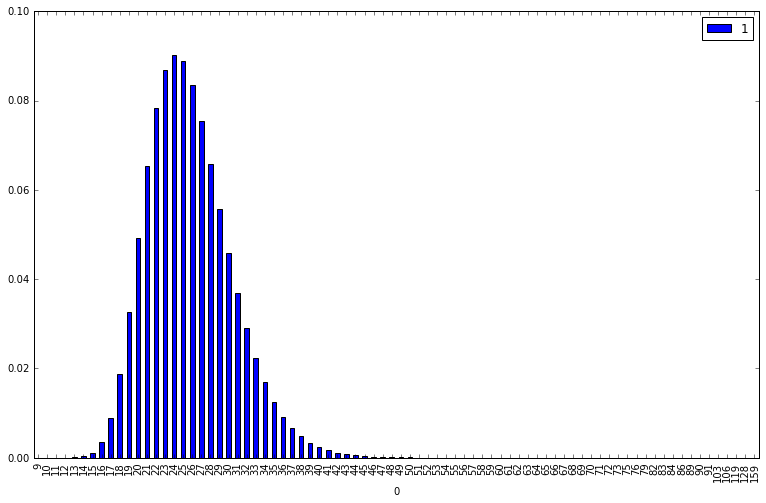

In [207]:
!cat part-00000 | sort -k1,1n > hist.txt
density_df = pd.read_csv("hist.txt", sep="\t", header=None)
density_df.plot(x=0, y=1, kind="bar", figsize=(13,8))

# 5.4

Synonym detection over 2Gig of Data

For the remainder of this assignment you will work with two datasets:

### 1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

DocA {X:20, Y:30, Z:5}
DocB {X:100, Y:20}
DocC {M:5, N:20, Z:5}


### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with you system.

In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes for the most frequent 10,000 words using cooccurence informationa based on
the words ranked from 1001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).

(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

In [213]:
%%writefile com.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
import re

class MRCoOccurenceMatrix(MRJob):
    
    def mapper(self, _, line):
        splits = [x.lower().strip() for x in line.split('\t')]
        ngram = splits[0]
        count = int(splits[1])
        words = [x.strip() for x in re.split(" ", ngram)]
#         stripes = {}
#         for i in range(len(words)):
#             for j in range(len(words)):
#                 if i != j:
#                     if words[i] not in stripes:
#                         stripes[words[i]] = {}
#                     if words[j] not in stripes[words[i]]:
#                         stripes[words[i]][words[j]] = 0
#                     stripes[words[i]][words[j]] += count
        stripes = []
        for i in range(len(words)):
            stripe = {}
            for j in range(len(words)):
                if i != j:
                    if words[j] not in stripe:
                        stripe[words[j]] = 0
                    stripe[words[j]] += count
            stripes.append(stripe)
        for i in range(len(words)):
            yield words[i], stripes[i]
        
    def combiner(self, word, stripeList):
        unifiedStripes = {}
        for stripe in stripeList:
            for k, v in stripe.iteritems():
                if k not in unifiedStripes:
                    unifiedStripes[k] = 0
                unifiedStripes[k] += v
        yield word, unifiedStripes
        
    
    def reducer(self, word, stripeList):
        unifiedStripes = {}
        for stripe in stripeList:
            for k, v in stripe.iteritems():
                if k not in unifiedStripes:
                    unifiedStripes[k] = 0
                unifiedStripes[k] += v
        yield word, unifiedStripes
            
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer
                  )
        ]    
        
        
if __name__ == '__main__':
    MRCoOccurenceMatrix.run()

Writing com.py


In [ ]:
!rm -rf mrJobOutput/
%time !python com.py filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt \
--output-dir mrJobOutput --no-output